In [19]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

In [20]:
non_feature_columns = ['Ticker Symbol', 'Period Ending', 'Sector', 'For Year', 'Next Qtr. Avg. Price']
less_useful_parameters = ["Add'l income/expense items", "Deferred Asset Charges", "Deferred Liability Charges", "Effect of Exchange Rate", "Minority Interest", "Misc. Stocks", "Non-Recurring Items", "Other Assets", "Other Current Assets", "Other Current Liabilities", "Other Equity", "Other Financing Activities", "Other Investing Activities", "Other Liabilities", "Other Operating Activities", "Other Operating Items"]

# Load the dataset
data = pd.read_csv('../data/merged_data.csv')

# Drop less useful fundamental parameters
data = data.drop(columns=less_useful_parameters)


In [21]:
# Select features and finalise the dataset for RF model

features = data.columns.difference(non_feature_columns)
X = data.drop(columns=non_feature_columns)
y = data['Next Qtr. Avg. Price']

rf_model_fs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_fs.fit(X, y)

feature_importances = rf_model_fs.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 features
selected_features = importance_df['Feature'].head(30).to_numpy()
print(f'Selected Features:\n{selected_features}')

final_data = pd.DataFrame()
final_data['Ticker Symbol'] = data['Ticker Symbol']
final_data['Period Ending'] = data['Period Ending']
final_data[selected_features] = data[selected_features]
final_data['Next Qtr. Avg. Price'] = data['Next Qtr. Avg. Price'].round(2)

final_data.to_csv('../data/rf_data.csv')


Selected Features:
['Total Revenue' 'Treasury Stock' 'Inventory' 'Common Stocks'
 'Changes in Inventories' 'Quick Ratio' 'Capital Surplus'
 'Total Current Liabilities' 'Fixed Assets' 'Intangible Assets'
 'Estimated Shares Outstanding' 'Profit Margin' 'Net Income' 'Cash Ratio'
 'Pre-Tax ROE' 'Total Liabilities & Equity' 'Interest Expense'
 'Capital Expenditures' 'Total Current Assets'
 'Equity Earnings/Loss Unconsolidated Subsidiary' 'Total Assets'
 'Earnings Before Tax' 'Net Income Applicable to Common Shareholders'
 'Investments' 'Net Cash Flows-Investing' 'Cost of Revenue' 'Gross Profit'
 'Depreciation' 'Retained Earnings' 'Operating Margin']


In [22]:
# Load the final data
data = pd.read_csv('../data/rf_data.csv')
features = data.columns.difference(non_feature_columns)

# Split data into train and test
def split_data(group, train_size=0.7):
    if len(group) > 1:
        train, test = train_test_split(group, train_size=train_size, shuffle=False)
    else:
        train, test = group, group
    return train, test

# Initialize empty DataFrames for training and testing data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Group by 'Ticker Symbol' and split the data
for symbol, group in data.groupby('Ticker Symbol'):
    train_group, test_group = split_data(group)
    train_data = pd.concat([train_data, train_group])
    test_data = pd.concat([test_data, test_group])

# Reset the index of the resulting DataFrames
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


train_data.to_csv('./outputs/rf_train_data.csv')
test_data.to_csv('./outputs/rf_test_data.csv')

X = data[features]
y = data['Next Qtr. Avg. Price']

X_train = train_data[features]
y_train = train_data['Next Qtr. Avg. Price']

X_test = test_data[features]
y_test = test_data['Next Qtr. Avg. Price']

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
rf_model_cv = RandomForestRegressor(n_estimators=100, random_state=42)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validate for MSE
cv_mse_scores = cross_val_score(rf_model_cv, X_scaled, y, cv=kf, scoring=mse_scorer)
cv_mse = -cv_mse_scores.mean()  # Negate the scores because greater_is_better=False for MSE
print(f'Mean Cross-Validated MSE: {cv_mse:.2f}')


Mean Cross-Validated MSE: 1874.00


In [25]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_scaled, y_train)
y_pred_test = rf_model.predict(X_test_scaled)

# Testing metrics
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f'MSE: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

MSE: 3192.24
R-squared: 0.64


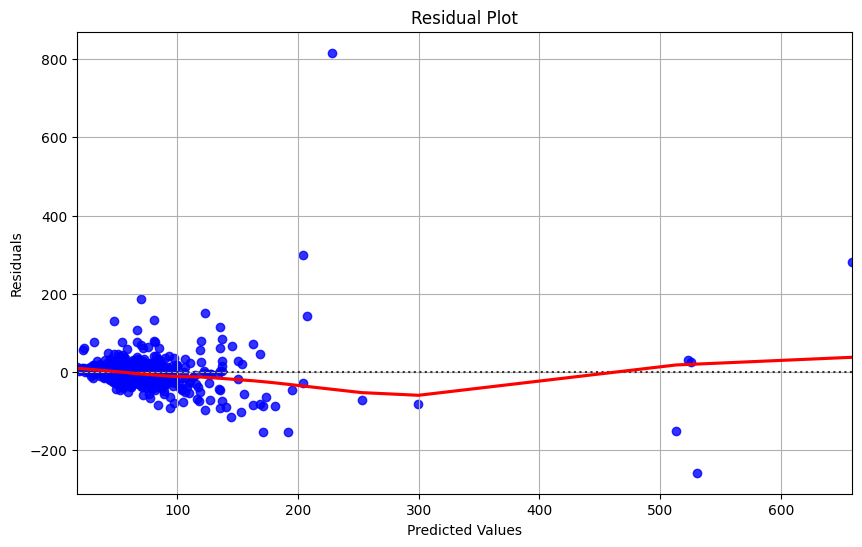

In [26]:
# Calculate residuals
residuals = y_test - y_pred_test

# Plot residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_test, y=residuals, lowess=True, color='blue', line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()



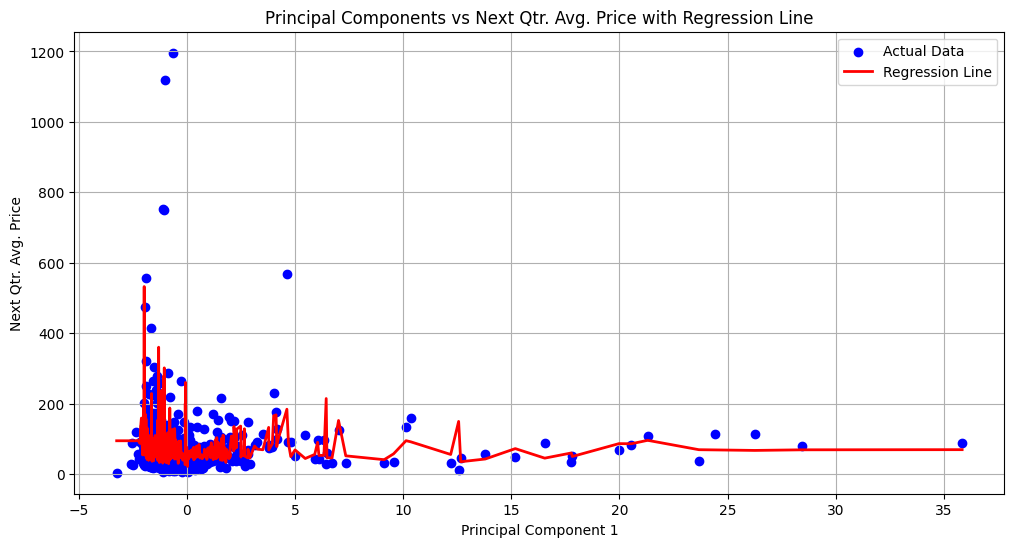

In [27]:
# Using PCA for visualisation purpose

pca = PCA(n_components=2)  # Reduce to 2 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

rf_model_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_pca.fit(X_train_pca, y_train)

y_pred_test = rf_model_pca.predict(X_test_pca)

plt.figure(figsize=(12, 6))

# Scatter plot for actual data points
plt.scatter(X_test_pca[:, 0], y_test, color='blue', label='Actual Data')

# Plot the regression fit line
sorted_indices = np.argsort(X_test_pca[:, 0])
plt.plot(X_test_pca[sorted_indices, 0], y_pred_test[sorted_indices], color='red', linewidth=2, label='Regression Line')

plt.xlabel('Principal Component 1')
plt.ylabel('Next Qtr. Avg. Price')
plt.title('Principal Components vs Next Qtr. Avg. Price with Regression Line')
plt.legend()
plt.grid(True)

# Display plot
plt.show()
